## MNIST Handwritten Digit Recognition

![Example of the dataset](mnist_plot.png)

Epoch 1 Loss: 0.006821521557867527
Epoch 2 Loss: 0.03405889868736267
Epoch 3 Loss: 0.03792627528309822


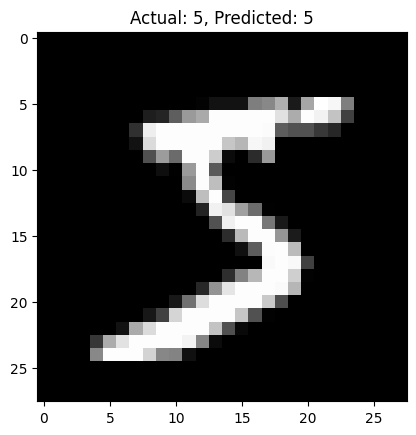

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

NUM_PIXELS = 28*28

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(NUM_PIXELS, 128)
        self.fc2 = nn.Linear(128, 10) # Output: 10 classes (digits 0-9)
        
    def forward(self, x: torch.Tensor):
        x = x.reshape(-1, NUM_PIXELS)  # Flatten image
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation (CrossEntropyLoss includes softmax)
        return x

# Initialize model, loss, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(3):  
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item()}")

# Test the model with a random image
image, label = trainset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Actual: {label}, Predicted: {torch.argmax(model(image.reshape(-1, NUM_PIXELS))).item()}")
plt.show()